In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Embedding, Concatenate
import pickle

Cargamos los datos con los que vamos a entrenar el modelo y comprobamos la distribución de las categorias a entrenar

In [2]:
df = pd.read_csv('df_filtrado_22.csv', sep='\t')

In [3]:
df['CLIN_SIG'].value_counts()

pathogenic           300000
benign               300000
likely_benign        300000
likely_pathogenic    300000
Name: CLIN_SIG, dtype: int64

In [4]:
df

,Allele,Consequence,Amino_acids,Codons,IMPACT,FLAGS,BIOTYPE,USED_REF,gnomADg_AF,gnomADg_AFR_AF,...,gnomADg_ASJ_AF,gnomADg_EAS_AF,gnomADg_FIN_AF,gnomADg_MID_AF,gnomADg_NFE_AF,gnomADg_OTH_AF,gnomADg_SAS_AF,CLIN_SIG,SOMATIC,PHENO
0,-,frameshift_variant,GT/X,gGCACc/gc,HIGH,-,protein_coding,GTGC,0.000216,0.000198,...,0.000220,0.000169,0.000219,0.000208,0.000227,0.000223,0.000191,pathogenic,-,1
1,A,intron_variant,-,-,MODIFIER,-,protein_coding,G,0.000216,0.000198,...,0.000220,0.000169,0.000219,0.000208,0.000227,0.000223,0.000191,pathogenic,"0,1","1,1"
2,A,intron_variant,-,-,MODIFIER,-,protein_coding,C,0.076960,0.080700,...,0.026820,0.000578,0.091320,0.050630,0.092740,0.071290,0.025330,benign,-,1
3,T,3_prime_UTR_variant,-,-,MODIFIER,-,protein_coding,C,0.785400,0.944400,...,0.741100,0.930700,0.781300,0.794300,0.684900,0.783500,0.915900,benign,-,1
4,T,synonymous_variant,T,acG/acT,LOW,-,protein_coding,G,0.001915,0.003308,...,0.001389,0.001369,0.001326,0.001531,0.001365,0.001770,0.001385,likely_benign,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,G,synonymous_variant,S,tcC/tcG,LOW,-,protein_coding,C,0.000007,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,likely_benign,-,1
1199996,A,intron_variant,-,-,MODIFIER,-,protein_coding,C,0.004722,0.015730,...,0.000288,0.000000,0.000000,0.000000,0.000441,0.002390,0.000000,likely_benign,-,1
1199997,C,missense_variant,V/G,gTg/gGg,MODERATE,-,protein_coding,A,0.000035,0.000035,...,0.000043,0.000042,0.000023,0.000033,0.000037,0.000039,0.000038,likely_pathogenic,-,1
1199998,T,splice_donor_variant,-,-,HIGH,-,protein_coding,G,0.000035,0.000035,...,0.000043,0.000042,0.000023,0.000033,0.000037,0.000039,0.000038,likely_pathogenic,-,1


## PREPROCESAMIENTO

Definimos cuales van a ser las variables categóricas y cuales las numéricas para entrenar el modelo

In [6]:
# Preprocesamiento de características categóricas
categorical_features = ['Allele', 'Consequence', 'Amino_acids', 'Codons', 'IMPACT', 'FLAGS',
       'BIOTYPE', 'USED_REF','SOMATIC', 'PHENO']
# Preprocesamiento de características numéricas
numerical_features = ['gnomADg_AF', 'gnomADg_AFR_AF', 'gnomADg_AMI_AF',
       'gnomADg_AMR_AF', 'gnomADg_ASJ_AF', 'gnomADg_EAS_AF', 'gnomADg_FIN_AF',
       'gnomADg_MID_AF', 'gnomADg_NFE_AF', 'gnomADg_OTH_AF', 'gnomADg_SAS_AF']

Le damos una etiqueda a cada caracteristica categórica:

In [7]:
encoders = {}
for column in categorical_features:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    encoders[column] = le


Lo mismo con la categoría a predecir

In [8]:
le2 = LabelEncoder()
df['CLIN_SIG'] = le2.fit_transform(df['CLIN_SIG'])
target_encoder_2 = le2

## PREPARACIÓN DEL MODELO

Separamos los datos en entrenamiento (80%), validacion(10%) y test(10%): 

In [9]:

X_train, X_test, y_train, y_test = train_test_split(df[categorical_features + numerical_features], df['CLIN_SIG'], random_state=1)


X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)


Definimos la funcion que creara el modelo creando tantas capas emmbeding como caracteristicas tengamos:

In [10]:
def create_model():
    inputs = []
    embeddings = []

    for categorical_feature in categorical_features:
        _input = Input(shape=(1,))
        _embedding = Embedding(input_dim=np.max(df[categorical_feature])+1, output_dim=10)(_input)
        _embedding = Flatten()(_embedding)
        inputs.append(_input)
        embeddings.append(_embedding)

    numerical_input = Input(shape=(len(numerical_features),))
    inputs.append(numerical_input)
    embeddings.append(numerical_input)

    x = Concatenate()(embeddings)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs, output)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


Definimos un earlystopping:

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

Creamos el modelo

In [16]:
model = create_model()

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

 dense_8 (Dense)                (None, 1024)         525312      ['dense_7[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 1024)         0           ['dense_8[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 4)            4100        ['dropout_1[0][0]']              
                                                                                                  
Total params: 2,445,690
Trainable params: 2,445,690
Non-trainable params: 0
__________________________________________________________________________________________________


Entrenamos el modelo:

In [18]:
history = model.fit([X_train[feature].values for feature in categorical_features] + [X_train[numerical_features].values], y_train.values, 
                    validation_data=([X_val[feature].values for feature in categorical_features] + [X_val[numerical_features].values], y_val.values), 
                    epochs=50, batch_size=512, callbacks=[early_stopping])


Epoch 1/50
1758/1758 [==============================] - 72s 40ms/step - loss: 0.4638 - accuracy: 0.8051 - val_loss: 0.3747 - val_accuracy: 0.8650
Epoch 2/50
1758/1758 [==============================] - 74s 42ms/step - loss: 0.2958 - accuracy: 0.8850 - val_loss: 0.2690 - val_accuracy: 0.8978
Epoch 3/50
1758/1758 [==============================] - 79s 45ms/step - loss: 0.2591 - accuracy: 0.8995 - val_loss: 0.2571 - val_accuracy: 0.8973
Epoch 4/50
1758/1758 [==============================] - 82s 47ms/step - loss: 0.2385 - accuracy: 0.9084 - val_loss: 0.2265 - val_accuracy: 0.9136
Epoch 5/50
1758/1758 [==============================] - 80s 46ms/step - loss: 0.2258 - accuracy: 0.9136 - val_loss: 0.2203 - val_accuracy: 0.9167
Epoch 6/50
1758/1758 [==============================] - 74s 42ms/step - loss: 0.2176 - accuracy: 0.9165 - val_loss: 0.2252 - val_accuracy: 0.9135
Epoch 7/50
1758/1758 [==============================] - 99s 57ms/step - loss: 0.2135 - accuracy: 0.9179 - val_loss: 0.2127 -

Realizamos predicciones con el conjunto de test:

In [19]:

y_pred_probs = model.predict([X_test[feature] for feature in categorical_features] + [X_test[numerical_features]])


y_pred = np.argmax(y_pred_probs, axis=1)


4688/4688 [==============================] - 15s 3ms/step


Guardar Modelo

In [21]:
model.save('variant_model_good_2.h5')
model.save('variant_model_good_2')

INFO:tensorflow:Assets written to: variant_model_good_2\assets


Guardar encoders

In [7]:
for feature in categorical_features:
    with open(f'{feature}_encoder.pkl', 'wb') as f:
        pickle.dump(encoders[feature], f)


In [21]:
classes = 'CLIN_SIG'
with open(f'{classes}_encoder.pkl', 'wb') as f:
        pickle.dump(le2, f)

Cargar encoders:

In [48]:
encoders = {}
for feature in categorical_features:
    with open(f'{feature}_encoder.pkl', 'rb') as f:
        encoders[feature] = pickle.load(f)

In [22]:
with open('CLIN_SIG_encoder.pkl', 'rb') as f:
    clin_sig_encoder = pickle.load(f)

classes = clin_sig_encoder.classes_

In [23]:
classes

array(['benign', 'likely_benign', 'likely_pathogenic', 'pathogenic'],
      dtype=object)

Sacamos el heatmap:

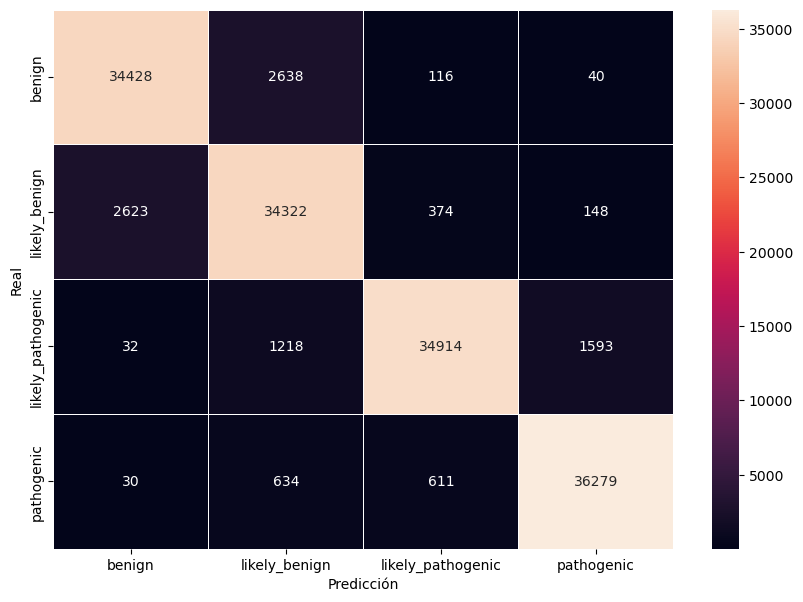

In [24]:

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, linewidths=.6)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Mostramos datos en forma de dataframe y de matriz de confusión:

In [25]:
df = pd.DataFrame(cm)

df.columns = [classes]
df.index = [classes]

print(df)

                  benign likely_benign likely_pathogenic pathogenic
benign             34428          2638               116         40
likely_benign       2623         34322               374        148
likely_pathogenic     32          1218             34914       1593
pathogenic            30           634               611      36279


In [26]:
report = classification_report(y_test, y_pred,target_names=classes)

print(report)

                   precision    recall  f1-score   support

           benign       0.93      0.92      0.93     37222
    likely_benign       0.88      0.92      0.90     37467
likely_pathogenic       0.97      0.92      0.95     37757
       pathogenic       0.95      0.97      0.96     37554

         accuracy                           0.93    150000
        macro avg       0.93      0.93      0.93    150000
     weighted avg       0.93      0.93      0.93    150000



Mostramos gráficas de entrenamiento:

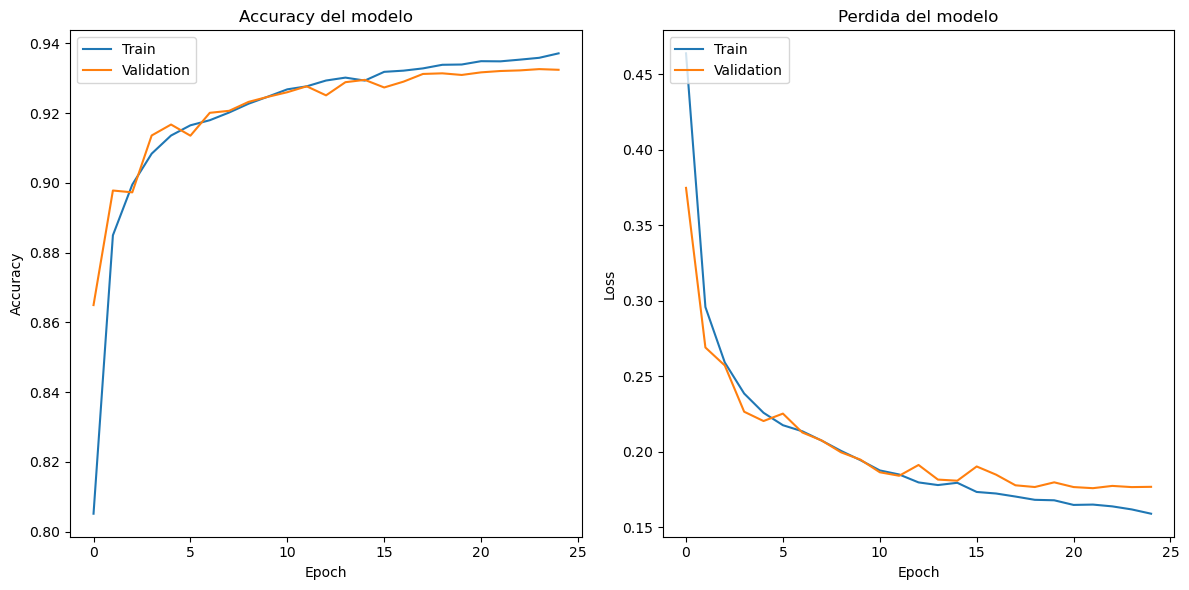

In [27]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### CARGAR MODELO SI ES NECESARIO

In [6]:
model = tf.keras.models.load_model('variant_model_good_2')